In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.measure import block_reduce
import pickle

from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter as gf

from morans import morans

In [2]:
# Create a square 2D Ising Lattice 
# Initial magnetization state of the elements in the lattice is uniform (u) or randomized (r)

class IsingLattice:

    def __init__(self, initial_state, size, J, mask = None, h=0):
        self.size = size # size of each dimension
        

        if J is np.ndarray:
            self.J = J
        else:
            self.J = J*np.ones((size,size))
        self.h = h*np.ones((self.size,self.size)) # array of (size,size)
        
        self.system = self._build_system(initial_state)

        if mask is None:
            self.mask = np.ones((size,size))
        else:
            self.mask = mask

        # self.T = temperature*np.ones((self.size,self.size)) # array of (size,size)
        # self.k = 1.38 * (10**(-23))

    @property
    def sqr_size(self):
        return (self.size, self.size)

    def _build_system(self, initial_state):
        """Build the system

        Build either a randomly distributed system or a homogeneous system (for
        watching the deterioration of magnetization

        Parameters
        ----------
        initial_state : str: "r" for random or "u" for uniform (all +1)
            Initial state of the lattice. 
        """

        if initial_state == 'r':
            system = np.random.choice([-1, 1], self.sqr_size)
        elif initial_state == 'u':
            system = np.ones(self.sqr_size)
        else:
            raise ValueError(
                "Initial State must be 'r', random, or 'u', uniform"
            )

        return system
    
    def _bc(self, i):
        """Apply periodic boundary condition

        Check if a lattice site coordinate falls out of bounds. If it does,
        apply periodic boundary condition

        Assumes lattice is square

        Parameters
        ----------
        i : int
            lattice site coordinate

        Return
        ------
        int
            corrected lattice site coordinate
        """
        if i >= self.size:
            return 0
        if i < 0:
            return self.size - 1
        else:
            return i

    def energy(self, N, M):
        """Calculate the energy of spin interaction at a given lattice site
        i.e. the interaction of a Spin at lattice site n,m with its 4 neighbors

        - S_n,m*(S_n+1,m + Sn-1,m + S_n,m-1, + S_n,m+1)

        Parameters
        ----------
        N : int
            lattice site coordinate
        M : int
            lattice site coordinate

        Return
        ------
        float
            energy of the site
        """
        interactions = -self.system[N, M]*self.J[N,M]*(self.system[self._bc(N - 1), M] + self.system[self._bc(N + 1), M]+ self.system[N, self._bc(M - 1)] + self.system[N, self._bc(M + 1)])
        external = -self.system[N, M]*self.h[N,M]
        energy = interactions + external
        return energy
    
    @property
    def internal_energy(self):
        e = 0
        E = 0
        E_2 = 0

        for i in range(self.size):
            for j in range(self.size):
                e = self.energy(i, j)
                E += e
                E_2 += e**2

        U = (1./self.size**2)*E
        U_2 = (1./self.size**2)*E_2

        return U, U_2

    @property
    def heat_capacity(self,temp):
        U, U_2 = self.internal_energy
        return np.mean((U_2 - U**2)/np.power(temp,2))

    @property
    def magnetization(self):
        """Find the overall magnetization of the system
        """
        return np.sum(self.system)/self.size**2   #Maybe get rid of abs or add it
    
def hc(lattice,temp):
    U, U_2 = lattice.internal_energy
    return np.mean((U_2 - U**2)/np.power(temp,2))

def create_params():
    try:
        rng = np.random.default_rng()
    except AttributeError:
        rng = np.random.RandomState()


    J_mean = 2**(5*rng.uniform())  # why 5? can choose something else
    J_std = 0.3*rng.uniform()*J_mean # 0 - 30% of mean

    #J = J_mean*np.ones((size,size)) + J_std*(np.random.randn(size,size))

    Tc = 2*J_mean/(np.log(1+np.sqrt(2))) # critical temperature

    null = rng.choice([0,1])

    offset_dir =rng.choice([-1,1])
    spatial_coarse_graining = rng.choice(np.arange(3,8))
    #temporal_coarse_graining = rng.choice(np.arange(3,8))
    #spatial_coarse_graining = 1
    temporal_coarse_graining = 1
    epoch_len = 5000

    if null: # No Transition run (does not go through Tc)
        Tb1 = Tc * (0.2 + 0.2*rng.uniform())
        Tb2 = Tc * (0.4 + 0.2*rng.uniform())
            
        Tbounds = Tc + offset_dir*np.array([Tb1,Tb2])
        Tbounds = rng.permutation(Tbounds)

    else: # Transition Run (goes through Tc)
        Tb1 = Tc * (0.7 - 0.4*rng.uniform())
        Tb2 = Tc * (1.2 + 0.4*rng.uniform())
        #Tbounds = np.sort(np.array([Tb1,Tb2]))[::-1] # descending order, why ?? *******************
        Tbounds = rng.choice(([[Tb1,Tc],[Tc,Tb2]]))
        Tbounds = rng.permutation(Tbounds)
    
    target_duration = rng.choice(list(range(575,675)))


    run_params = {'J_mean':J_mean, 'J_std':J_std, 'Tc':Tc, 
                    'spatial_coarse_graining':spatial_coarse_graining,
                    'temporal_coarse_graining':temporal_coarse_graining,
                    'epoch_len':epoch_len, 'null':null,'Tbounds':Tbounds,'target_duration':target_duration}
    

    return run_params



def run(lattice, temps,burn_time , epoch_len = 1000):
    """Run the simulation
    """
    # System = []
    # Magnetization = []
    # Heat_Capacity = []
    epochs = temps.shape[0]

    System = np.zeros((epochs,lattice.system.shape[0],lattice.system.shape[1]))
    Magnetization = np.zeros(epochs)
    Heat_capacity = np.zeros(epochs)

    for epoch,temp in enumerate(temps):    

        step_avg = np.zeros((lattice.size,lattice.size)) # why are we taking step average

        for step in range(epoch_len):
            # Randomly select a site on the lattice
            N, M = np.random.randint(0, lattice.size, 2)

            # Calculate energy of a flipped spin
            dE = -2*lattice.energy(N, M)

            # "Roll the dice" to see if the spin is flipped
            if dE <= 0.:
                lattice.system[N, M] *= -1
            elif np.exp(-dE/(temp)) > np.random.rand():
                lattice.system[N, M] *= -1

            step_avg += lattice.system

        step_avg = step_avg/epoch_len

        # check and account for burn time (write an if statement)
        System[epoch,:,:] = step_avg
        Magnetization[epoch] = lattice.magnetization
        Heat_capacity[epoch] = hc(lattice,temp)

        #System.append(step_avg)
        #Magnetization.append(lattice.magnetization) #should we not take average magnetization?
        #Heat_Capacity.append(lattice.heat_capacity(temp=temp))

        output= {"System":System,"Magnetization":Magnetization,"Heat_capacity":Heat_capacity}

    return output



def ising_run(temps, size, J, burn_time, epoch_len, initial_state):
    
    
    lattice = IsingLattice(initial_state=initial_state, size=size, J=J)
    out_vars = run(lattice=lattice, temps=temps, burn_time=burn_time, epoch_len=epoch_len)

    return out_vars


def matrix_autocorr(s_flatten,lag):
    sbar = np.mean(s_flatten,axis=0)
    s_full = s_flatten - np.tile(sbar,(s_flatten.shape[0],1))
    
    s_0 = s_full[:s_flatten.shape[0]-lag,:]
    s_shift = s_full[lag:s_flatten.shape[0],:]
    
    ac_num = np.nansum(np.multiply(s_0,s_shift),axis=0)
    ac_denom = np.nansum(np.multiply(s_full,s_full),axis=0)
    
    ac = np.divide(ac_num,ac_denom)
    
    return ac



def temporal_ews(s,t_roll_window):
    s = s.reshape(s.shape[0],-1)
    
    t_var = np.zeros(s.shape)
    t_skew = np.zeros(s.shape)
    t_kurt = np.zeros(s.shape)
    t_corr_1 = np.zeros(s.shape)
    t_corr_2 = np.zeros(s.shape)
    t_corr_3 = np.zeros(s.shape)
    
    for j in range(s.shape[0]-t_roll_window):
        window_end = j+t_roll_window
        s_window = s[j:window_end,:]
        
        t_var[window_end,:] = np.nanvar(s_window,axis=0)
        t_skew[window_end,:] = skew(s_window,axis=0,nan_policy='omit')
        t_kurt[window_end,:] = kurtosis(s_window,axis=0,nan_policy='omit')
        
        t_corr_1[window_end,:] = matrix_autocorr(s_window,1)
        t_corr_2[window_end,:] = matrix_autocorr(s_window,2)
        t_corr_3[window_end,:] = matrix_autocorr(s_window,3)

    
    return {'t_var':t_var,
            't_skew':t_skew,
            't_kurt':t_kurt,
            't_corr_1':t_corr_1,
            't_corr_2':t_corr_2,
            't_corr_3':t_corr_3}



def compute_ews(s,t_roll_window):
    # s has dims [t,x,y]
    #
    # for gaussian filter, smooth param is sigma in [temporal,spatial] dimensions
    #
    # as of now filter is only applied when computing temporal EWS -> if smooth_param[1] != 0,
    # this will need to be reimplemented to achieve desired behavior
    
    # Temporal EWS:
    #t_roll_window = int(np.floor(t_roll_window_frac*s.shape[0]))
    
    t_ews = temporal_ews(s,t_roll_window)
    
   

    t_var = np.nanmean(t_ews['t_var'],axis=1)
    t_skew = np.nanmean(t_ews['t_skew'],axis=1)
    t_kurt = np.nanmean(t_ews['t_kurt'],axis=1)
    t_corr_1 = np.nanmean(t_ews['t_corr_1'],axis=1)
    t_corr_2 = np.nanmean(t_ews['t_corr_2'],axis=1)
    t_corr_3 = np.nanmean(t_ews['t_corr_3'],axis=1)
    
    # Spatial EWS:
    s_flatten = s.reshape(s.shape[0],-1)
    s_flatten = s_flatten[t_roll_window:,:]
    
    x_var = np.zeros(s.shape[0])
    x_skew = np.zeros(s.shape[0])
    x_kurt = np.zeros(s.shape[0])
    x_corr_1 = np.zeros(s.shape[0])
    x_corr_2 = np.zeros(s.shape[0])
    x_corr_3 = np.zeros(s.shape[0])
    
    x_var[t_roll_window:] = np.nanvar(s_flatten,axis=1)
    x_skew[t_roll_window:] = skew(s_flatten,axis=1,nan_policy='omit')
    x_kurt[t_roll_window:] = kurtosis(s_flatten,axis=1,nan_policy='omit')

    
    x_corr_1[t_roll_window:] = morans(s[t_roll_window:,:,:],1,periodic=False)
    x_corr_2[t_roll_window:] = morans(s[t_roll_window:,:,:],2,periodic=False)
    x_corr_3[t_roll_window:] = morans(s[t_roll_window:,:,:],3,periodic=False)
    
    x = np.vstack((t_var,t_skew,t_kurt,t_corr_1,t_corr_2,t_corr_3,
                   x_var,x_skew,x_kurt,x_corr_1,x_corr_2,x_corr_3))
    
    return x.T
            

In [3]:
n_runs = 10
burn_time = 50
target_size = 15
#target_duration = 400

#Output=pd.DataFrame(columns=["System","System_cg","Magnetization","Heat_capacity","null"])
Result=pd.DataFrame(columns=["System","System_cg","Magnetization","Heat_capacity","Tc","Tbounds","null"])


for r in range(n_runs):

    print(f"Run {r}")
    params = create_params()
    J_mean = params["J_mean"]
    J_std = params["J_std"]
    Tc = params["Tc"]
    spatial_coarse_graining = params["spatial_coarse_graining"]
    temporal_coarse_graining = params["temporal_coarse_graining"]
    epoch_len = params["epoch_len"]
    null = params["null"]
    Tbounds = params["Tbounds"]
    target_duration = params["target_duration"]

    sim_size = target_size*spatial_coarse_graining
    sim_duration = target_duration*temporal_coarse_graining
    sim_burn_time = burn_time*temporal_coarse_graining
    temps = np.linspace(Tbounds[0],Tbounds[1],sim_duration-(null*100))

    if temps[0] > Tc:
        initial_state = 'r'
    else:
        initial_state = 'u'


    if not null:
        if (Tbounds[0]>=Tc and Tbounds[0]>=Tc):
            temps = temps[-50::]
            initial_state = 'r'
        else:
            temps = temps[:-50:]
            initial_state = 'u'



    J = J_mean*np.ones((sim_size,sim_size)) + J_std*(np.random.randn(sim_size,sim_size))
    

    output = ising_run(temps,sim_size,J,burn_time,epoch_len,initial_state)

    System = output["System"]
    Magnetization = output["Magnetization"]
    Heat_capacity = output["Heat_capacity"]

    System_cg = block_reduce(System,block_size=(temporal_coarse_graining,spatial_coarse_graining,spatial_coarse_graining),func=np.nanmean)

    output["System_cg"]=System_cg
    output["null"]=null
    #out = pd.DataFrame(({"System":System,"System_cg":System_cg,"Magnetization":Magnetization,"Heat_capacity":Heat_capacity,"null":null}))
    #out = pd.DataFrame(output)
    Result.loc[len(Result.index)] = [System,System_cg,Magnetization,Heat_capacity,Tc,Tbounds,null]
    #Result = pd.concat((Result,out),axis=0,ignore_index=True)

    

    


Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [4]:
with open("Train_Data_13","wb") as file:
    pickle.dump(Result,file)

In [5]:
Result

,System,System_cg,Magnetization,Heat_capacity,Tbounds,null
0,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[0.9862879999999999, 0.9778880000000001, 1.0...","[0.9583333333333334, 0.9461111111111111, 0.944...","[0.6461465796763235, 0.7157265027354102, 0.678...","[8.96689861023819, 5.160391347763964]",1
1,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[1.0, 1.0, 1.0, 1.0, 0.9057333333333334, 0.7...","[0.9891975308641975, 0.9722222222222222, 0.975...","[0.217276087664407, 0.3719397668774735, 0.3514...","[4.919419377038574, 3.150898258452285]",1
2,"[[[-1.0, -1.0, -1.0, 0.668, -0.6596, -0.9044, ...","[[[-0.2336111111111111, 0.14765555555555554, 0...","[0.016589506172839507, 0.02353395061728395, 0....","[0.7198991907996667, 0.7071088914067584, 0.720...","[4.979010236216632, 3.5861362591265005]",0
3,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[0.969475, 1.0, 1.0, 1.0, 0.86355, 1.0, 1.0,...","[0.9887152777777778, 0.984375, 0.9852430555555...","[0.5338636145428539, 0.5664143663177067, 0.574...","[35.454468831698236, 24.608477986854908]",1
4,"[[[-1.0, -1.0, -1.0, -0.048, -1.0, -1.0, -0.75...","[[[-0.26927999999999996, -0.030367999999999985...","[0.006111111111111111, -0.0077777777777777776,...","[0.40316028975147244, 0.42043555192192333, 0.4...","[3.81266037251837, 5.65516714031047]",0
5,"[[[0.9968, -0.7428, -0.1464, 0.3964, 0.286, -0...","[[[-0.41558888888888884, 0.04193333333333333, ...","[-0.02662037037037037, -0.020833333333333332, ...","[0.3216098457130035, 0.34129674078380573, 0.34...","[53.28405952102407, 42.84063446736536]",1
6,"[[[-0.204, -0.3888, -0.3488, 0.0856, -0.5588, ...","[[[-0.44195555555555555, 0.09786666666666666, ...","[-0.0787037037037037, -0.047839506172839504, -...","[0.7356305830845342, 0.8355084368410711, 0.772...","[6.7981911334745595, 5.043357697942728]",0
7,"[[[-1.0, -0.6388, 1.0, -1.0, 0.5328, -0.0568, ...","[[[-0.017322222222222215, -0.08226666666666667...","[-0.027391975308641976, -0.020833333333333332,...","[2.4711380972000363, 2.3988993758476194, 2.190...","[16.02721973791677, 8.10735559082229]",0
8,"[[[0.7828, -0.438, 0.3188, 0.0712, 0.476, -0.3...","[[[0.06960000000000001, 0.14671111111111113, -...","[-0.05092592592592592, -0.06327160493827161, -...","[0.49836058253738186, 0.4882682474333014, 0.51...","[2.711407882178888, 3.6124776355359853]",0
9,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[0.9984567901234568, 0.9953703703703703, 0.998...","[0.6581035994422263, 0.7483237526158919, 0.679...","[21.188839084494933, 33.491062134512056]",1


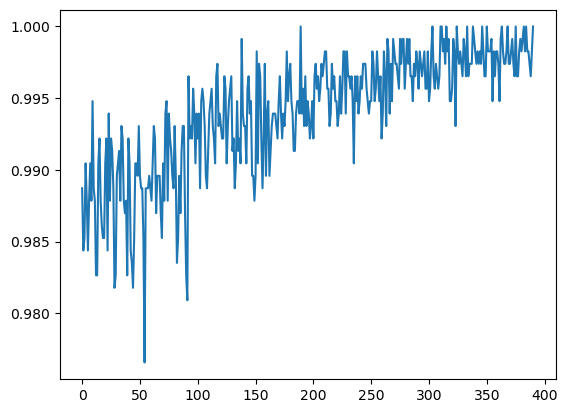

In [10]:
mag=Result["Magnetization"][3]
plt.plot(mag);

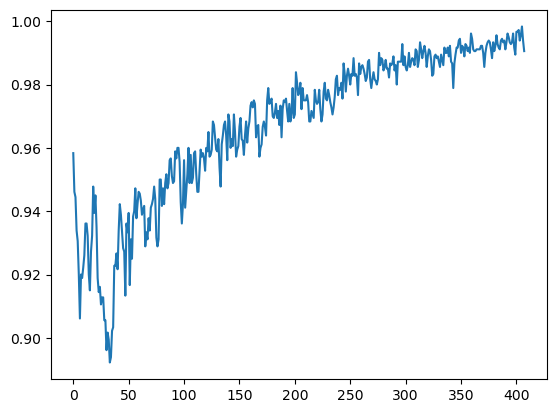

In [7]:
plt.plot(mag)